In [1]:
import pandas as pd

df = pd.read_csv('images_3.csv')
df

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,Top
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,Top
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
3,5d3a1404-697f-479f-9090-c1ecd0413d27,Bottoms
4,b0c03127-9dfb-4573-8934-1958396937bf,Top
...,...,...
4958,female-casual-peach-color-jeans-female-casual-...,Bottoms
4959,lilac-jeans-wooden-background-lilac-jeans-wood...,Bottoms
4960,jeans-image-table-48097904,Bottoms
4961,jeans-white-background-classical-isolated-clos...,Bottoms


# Encode labels, take sample of data into train/valid/test

In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df.label)
labels

array([3, 3, 2, ..., 0, 0, 0])

In [3]:
images = df.iloc[:, 0]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(images, labels):
    train_x, test_x = images[train_index], images[test_index]
    train_y, test_y = labels[train_index], labels[test_index]

In [5]:
train_x = train_x.to_numpy()

In [6]:
for train_index, valid_index in ss.split(train_x, train_y):
    train_x, valid_x = train_x[train_index], train_x[valid_index]
    train_y, valid_y = train_y[train_index], train_y[valid_index]

# Get all images loaded in from sample and convert to tensor

In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def get_images(path_list):
    train_img = []
    for filename in path_list:
        path = 'images_compressed/' + filename + '.jpg'
        img = imread(path, as_gray=True)
        img = resize(img, (100, 100))
        img /= 255.0
        img = img.astype('float32')
        train_img.append(img)
    return np.asarray(train_img)

In [8]:
train_x_images = get_images(train_x)

In [9]:
train_x_images.shape

(3176, 100, 100)

In [10]:
valid_x_images = get_images(valid_x)
test_x_images = get_images(test_x)

In [11]:
import torch

train_x_torch = torch.from_numpy(train_x_images).unsqueeze(dim=1)
valid_x_torch = torch.from_numpy(valid_x_images).unsqueeze(dim=1)
test_x_torch = torch.from_numpy(test_x_images).unsqueeze(dim=1)

In [12]:
train_x_torch.shape

torch.Size([3176, 1, 100, 100])

In [13]:
train_y_torch = torch.from_numpy(train_y)
valid_y_torch = torch.from_numpy(valid_y)
test_y_torch = torch.from_numpy(test_y)
train_y_torch.shape

torch.Size([3176])

In [14]:
# use gpu if available
if torch.cuda.is_available():
    train_x_torch = train_x_torch.cuda()
    train_y_torch = train_y_torch.cuda()
    valid_x_torch = valid_x_torch.cuda()
    valid_y_torch = valid_y_torch.cuda()
    test_x_torch = test_x_torch.cuda()
    test_y_torch = test_y_torch.cuda()
    

In [15]:
train = list(zip(train_x_torch, train_y_torch.to(dtype=torch.long)))
test = list(zip(test_x_torch, test_y_torch.to(dtype=torch.long)))
valid = list(zip(valid_x_torch, valid_y_torch.to(dtype=torch.long)))

In [16]:
# put everything into a data loader because too much data for gpu

from torch.utils.data import DataLoader

trainloader = DataLoader(train, batch_size=16)
testloader = DataLoader(test, batch_size=16)
validloader = DataLoader(valid, batch_size=16)

# Create CNN model

In [17]:
from torch import nn

# need to figure out what the numbers in Conv2d and other parts are / what to use for them

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        # two layers for this cnn
        self.cnn_layers = nn.Sequential (
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=1),   # output = 94 x 94 x 32
            nn.BatchNorm2d(32),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 47 X 47 X 32
            # Defining another 2D convolution layer
            nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=1),  # output = 41 X 41 X 32
            nn.BatchNorm2d(32),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 20 X 20 X 32
            
            # Defining another 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # output = 20 x 20 x 64
            nn.BatchNorm2d(64),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 10 X 10 X 64
      
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 4)
        )
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.linear_layers(x)
        return x

In [18]:
from torch import optim

model = ConvNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6400, out_features=4, bias=True)
  )
)


In [19]:
# Training loop

train_losses = []
valid_losses = []

epochs = 10
for epoch in range(epochs):
    train_loss = 0.
    valid_loss = 0.
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            train_y = labels[i]
            train_total += 1
            if train_y.item() == hyp:
                train_correct += 1
                
    train_losses.append(train_loss/len(trainloader))
    
    model.eval()
    for images, labels in validloader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            valid_y = labels[i]
            valid_total += 1
            if valid_y.item() == hyp:
                valid_correct += 1
                
    valid_losses.append(valid_loss/len(validloader))
    
    print('At epoch', epoch, 'loss =', '%.3g'%(train_loss/len(trainloader)), 'train acc=', '%.3g'%(train_correct/train_total), 'valid loss =', '%.3g'%(valid_loss/len(validloader)), 'valid acc =', '%.3g'%(valid_correct/valid_total))
    
import matplotlib.pyplot as plt



At epoch 0 loss = 0.683 train acc= 0.761 valid loss = 0.588 valid acc = 0.785
At epoch 1 loss = 0.453 train acc= 0.832 valid loss = 0.484 valid acc = 0.831
At epoch 2 loss = 0.338 train acc= 0.872 valid loss = 0.418 valid acc = 0.861
At epoch 3 loss = 0.26 train acc= 0.9 valid loss = 0.389 valid acc = 0.875
At epoch 4 loss = 0.207 train acc= 0.918 valid loss = 0.395 valid acc = 0.88
At epoch 5 loss = 0.164 train acc= 0.933 valid loss = 0.343 valid acc = 0.895
At epoch 6 loss = 0.13 train acc= 0.945 valid loss = 0.354 valid acc = 0.884
At epoch 7 loss = 0.103 train acc= 0.951 valid loss = 0.364 valid acc = 0.88
At epoch 8 loss = 0.0815 train acc= 0.958 valid loss = 0.363 valid acc = 0.885
At epoch 9 loss = 0.0626 train acc= 0.969 valid loss = 0.353 valid acc = 0.882


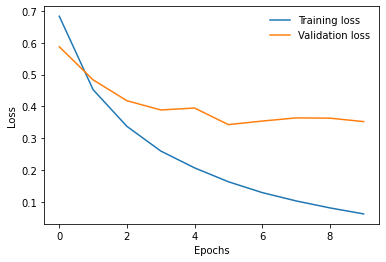

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [21]:
correct = 0.
total = 0.

hyps = []
correct_labels = []

model.eval()
for images, labels in testloader:
    for i in range(len(labels)):
        image = images[i].view(1, 1, 100, 100)
        with torch.no_grad():
            logps = model(image)
        allprobs = torch.exp(logps)
        prob = allprobs.tolist()[0]
        hyp = prob.index(max(prob))
        hyps.append(hyp)
        test_y = labels[i]
        total += 1
        correct_labels.append(test_y.item())
        if test_y.item() == hyp:
            correct += 1

print(correct/total)

0.8851963746223565


In [22]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(correct_labels, hyps)
cm

array([[218,   0,   7,  27],
       [  3,  19,   4,   8],
       [  9,   4,  66,   8],
       [ 36,   7,   1, 576]])

In [23]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, hyps, target_names=['Bottoms', 'Hats', 'Shoes', 'Top']))

              precision    recall  f1-score   support

     Bottoms       0.82      0.87      0.84       252
        Hats       0.63      0.56      0.59        34
       Shoes       0.85      0.76      0.80        87
         Top       0.93      0.93      0.93       620

    accuracy                           0.89       993
   macro avg       0.81      0.78      0.79       993
weighted avg       0.88      0.89      0.88       993

